In [ ]:

import pandas as pd 
from sklearn.metrics import r2_score
import re
import math
from nltk.stem.snowball import SnowballStemmer
import nltk
import  matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns; sns.set()
stop_words=set(stopwords.words('english'))
stop_words.add('none')
stemmer = SnowballStemmer("english")
data=pd.read_csv(r'C:\Users\x2125\Desktop\full.csv')
data=data.drop(columns=['rewards'])
data=data.dropna(subset=['reward'])
data[['reward']].describe()
data['reward'].hist()
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [117]:
data.columns

Index(['reward', 'id', 'name', 'description', 'dao', 'creat', 'creator',
       'audit_log', 'due_date', 'assignees', 'priority', 'status', 'tags',
       'review', 'done', 'comments', 'subtasks'],
      dtype='object')

In [151]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# build the linear efffect model
md = smf.mixedlm("reward ~ priority+status+time_to_due_date", data, groups=data["dao"])
mdf = md.fit()
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   reward     
No. Observations:   6886      Method:               REML       
No. Groups:         257       Scale:                46078.1955 
Min. group size:    1         Log-Likelihood:       -47219.9645
Max. group size:    666       Converged:            Yes        
Mean group size:    26.8                                       
---------------------------------------------------------------
                   Coef.    Std.Err.   z   P>|z| [0.025  0.975]
---------------------------------------------------------------
Intercept           146.164   31.044 4.708 0.000 85.319 207.009
priority              7.682    3.866 1.987 0.047  0.104  15.259
status                9.750    8.371 1.165 0.244 -6.656  26.157
time_to_due_date      0.000    0.000 2.726 0.006  0.000   0.000
Group Var        223150.738  102.112                           



In [146]:
def code_to_integers(column):
          unique_levels=data[column].unique().tolist()
          dic={k:v for (v,k) in list(zip(range(len(unique_levels)),unique_levels))}
          print(dic)
          data[column]=data[column].apply(lambda x: dic[x])

In [147]:
code_to_integers('priority')


{'NONE': 0, 'HIGH': 1, 'MEDIUM': 2, 'URGENT': 3, 'LOW': 4}


In [148]:
code_to_integers('status')
code_to_integers('dao')
code_to_integers('creator')

{'DONE': 0, 'TODO': 1, 'IN_REVIEW': 2}
{'dework': 0, 'all for climate dao': 1, 'dia dao': 2, 'paladin dao': 3, 'yoshi.exchange': 4, 'factorydao': 5, 'cere network': 6, 'lighthouse.world': 7, 'web3 marketing': 8, 'schnoodle đao': 9, 'stargate finance': 10, 'pagedao': 11, 'nil': 12, 'metahug dao': 13, 'harmoniesdao': 14, 'gravity dao': 15, 'charged particles': 16, 'paragons dao': 17, 'adventure networks': 18, 'dmeter': 19, 'bankless.se': 20, 'dune': 21, "próspera city-builders' network": 22, 'aragon network dao': 23, 'thedbc': 24, 'checkoutdao': 25, 'fractional finance': 26, 'citydao': 27, 'peaq network': 28, 'cartography - bdao': 29, 'stablenode': 30, 'equilib': 31, 'crypto sapiens': 32, 'sarcophagus community task boards': 33, 'y33t by daohaus': 34, 'paydece': 35, 'ξlimu dao': 36, 'citadao': 37, 'nation3': 38, 'itheum': 39, 'proof of webdev': 40, 'banklessdao website': 41, 'umoja protocol': 42, 'banklessdao | marketing department': 43, 'new south africa': 44, 'apollo crypto dao': 45, '

In [149]:
data.to_csv('data.csv')

In [ ]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["priority"] = data.priority
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

In [ ]:
data=data[data['reward']>0]
#data=data.drop(columns=[''])
fig, axis=plt.subplots(nrows=1,ncols=2)
data['reward'].hist(ax=axis[0])
data['log_reward']=data['reward'].apply(lambda x:math.log(x))
data['log_reward'].hist(ax=axis[1])

In [ ]:
data.isna().sum()
data.info()
data=data[data['status'].isin(['DONE','TODO','IN_REVIEW','IN_PROGESS'])]
data['due_date']=data['due_date'].transform(lambda x:'2024-01-01' if x=='None' else x)
#remove punctuations
data['name']=data['name'].str.lower().str.replace('[^\w\s]','')
data['description']=data['description'].apply(lambda x:re.sub('[^A-Za-z0-9]+',' ', str(x))).str.lower().str.split()
data['stemmed_description'] =data['description'].apply(lambda x: [i  for i in x if i.lower() not in stop_words])
data['stemmed_description'] =data['stemmed_description'].apply(lambda x: [stemmer.stem(y) for y in x])


In [120]:
data['stemmed_description']=data['stemmed_description'].apply(lambda x:' '.join(x))
data=data.drop(['description'],axis=1)


In [121]:
data.columns

Index(['reward', 'id', 'name', 'dao', 'creat', 'creator', 'audit_log',
       'due_date', 'assignees', 'priority', 'status', 'tags', 'review', 'done',
       'comments', 'subtasks', 'log_reward', 'stemmed_description'],
      dtype='object')

<Axes: xlabel='creat', ylabel='reward'>

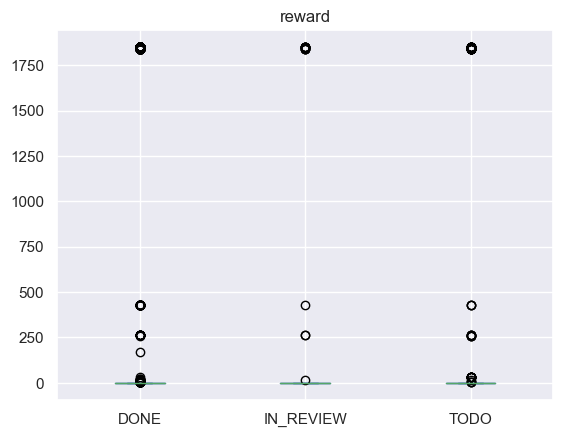

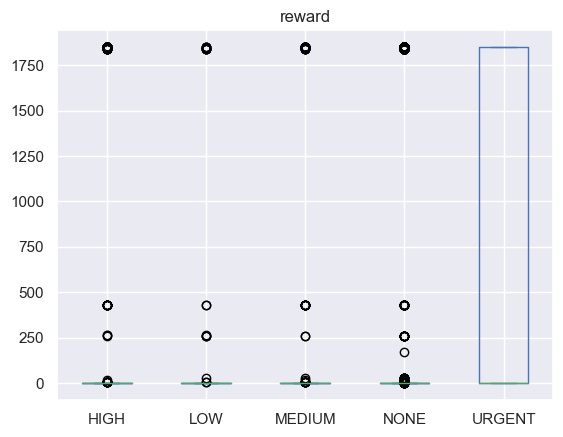

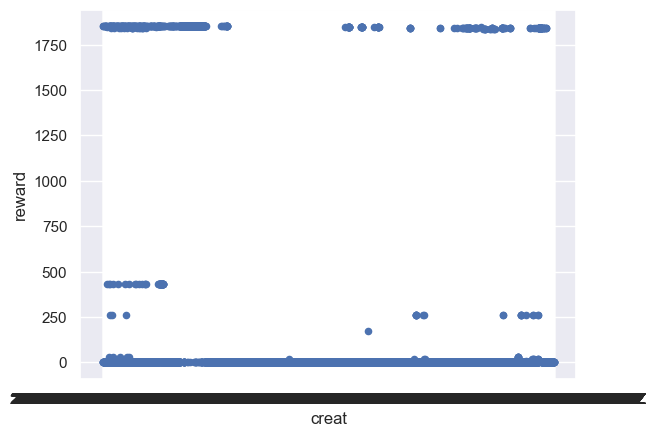

In [71]:
data.plot.box(column='reward',by='status')
data.plot.box(column='reward',by='priority')
data.plot.scatter(x='creat',y='reward')

In [122]:
data['creat']=data['creat'].transform(lambda x:x[:10])
data['due_date']=data['due_date'].transform(lambda x:x[:10])
data['creat']=data['creat'].transform(lambda x:pd.to_datetime(x) if x !='None' else x)
data['due_date']=data['due_date'].transform(lambda x:pd.to_datetime(x))
data['due_date']=data['due_date'].dt.normalize()
data['time_to_due_date']=data['due_date']-data['creat']
data['time_to_due_date']=pd.to_numeric(data['time_to_due_date'])
data=data[data['time_to_due_date']>0]
data.to_csv('data.csv')

In [155]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)

In [152]:
data['time_to_due_date']

6          691200000000000
28       51321600000000000
45         432000000000000
55         864000000000000
70        3110400000000000
               ...        
35823    59443200000000000
35838    59702400000000000
35846    59875200000000000
35901     4406400000000000
35976    63936000000000000
Name: time_to_due_date, Length: 6886, dtype: int64

In [153]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
target=data[['reward']]
variables=data.drop(columns=['reward'])
X_train,X_test,y_train,y_test=train_test_split(variables,target)

In [79]:
preprocessor=ColumnTransformer([('drop_columns','drop',['id','audit_log','subtasks','stemmed_description','tags','review','comments','name']),('OneHot',OneHotEncoder(handle_unknown='ignore'),['creator','dao','priority','status','assignees']),('StandardScalar',StandardScaler(),['time_to_due_date'])])

In [106]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
clf = Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',RandomForestRegressor(n_estimators=1000, max_depth=100,verbose=1))])

In [171]:
clf=Pipeline(steps=[("preprocessor", preprocessor),('regressor',GradientBoostingRegressor(random_state=0,learning_rate=0.01,n_estimators=1000,max_depth=100))])

In [172]:
clf.fit(X_train, y_train)

c:\Users\x2125\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['id', 'audit_log',
                                                   'subtasks',
                                                   'stemmed_description',
                                                   'tags', 'review', 'comments',
                                                   'name']),
                                                 ('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['creator', 'dao', 'priority',
                                                   'status', 'assignees']),
                                                 ('StandardScalar',
                                                  StandardScaler(),
                                                  ['time_to_due_date'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=100,
                                           n_estimators=1000,
                                           random_state=0))])

In [ ]:
clf.

In [173]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.859


In [174]:
predictions=clf.predict(X_test)
from sklearn.metrics import r2_score
r2_score([i[0] for i in y_test.values.tolist()], predictions)

0.8592967411008262

In [187]:
mean_squared_error([i[0] for i in y_test.values.tolist()], predictions)

48641.3905784953

In [197]:
X_test.iloc[439,]

id                                  b6bbe696-b47c-4435-8dbb-3bc70a91fdfb
name                                                           jin bonus
dao                                                                   59
creat                                                2023-02-27 00:00:00
creator                                                               73
audit_log              [{'id': 'c18c34b9-fd86-4aa1-81fa-07fc14e18ba4'...
due_date                                             2024-01-01 00:00:00
assignees                                                            jin
priority                                                               0
status                                                                 0
tags                                                                 NaN
review                                                               NaN
done                                            2023-02-27T18:49:15.707Z
comments                                           

In [210]:
import numpy as np 
len(np.array(np.where((predictions-np.array([i[0] for i in y_test.values.tolist()]))<=10)).tolist()[0])

1710

In [212]:
predictions[0]

1849.658215255537

In [198]:
[i[0] for i in y_test.values.tolist()][439]

1.79

In [215]:
target.describe()

,reward
count,6.886000e+03
mean,1.941535e+02
std,5.609072e+02
min,6.015500e-08
25%,2.952000e-01
50%,9.998000e-01
75%,1.000000e+00
max,1.850530e+03
